In [1]:
import geopandas as gpd
import numpy as np
from shapely.ops import nearest_points

In [2]:
import matplotlib.pyplot as plt

In [3]:
PATH_HDB = "./processed_n/hdb.geojson"
PATH_MRT = "./processed_n/mrt.geojson"
PATH_BUS = "./processed_n/bus.geojson"
PATH_HCEN  = "./processed_n/healthcare.geojson"
PATH_SCEN  = "./processed_n/recreation.geojson"

In [4]:
hdb = gpd.read_file(PATH_HDB)
mrt = gpd.read_file(PATH_MRT)
bus = gpd.read_file(PATH_BUS)
hcen = gpd.read_file(PATH_HCEN)
scen = gpd.read_file(PATH_SCEN)

In [5]:
hdb.columns

Index(['month', 'town', 'flat_type', 'storey_range', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'resale_price', 'resale_year',
       'resale_age', 'LAT', 'LNG', 'X', 'Y', 'geometry'],
      dtype='object')

In [6]:
# Add internal attributes
hdb['log_price'] = np.log(hdb['resale_price'])

In [7]:
# Define helpers to compute nearest distance
"""
Euclidean distance to its nearest target geometry
"""
def nearest_distance(origins, targets):
    return origins.geometry.apply(lambda g: targets.distance(g).min())

# Spatial distances
hdb['dist_mrt'] = nearest_distance(hdb, mrt)
hdb['dist_hcen'] = nearest_distance(hdb, hcen)
hdb['dist_scen'] = nearest_distance(hdb, scen)

In [8]:
# Bus stops count within 400m
hdb_buffer = hdb.copy()
"""
Replaces each HDB geometry (usually a point or polygon) with a buffer polygon having a radius of 400 meters.
Each buffer now represents the area around that HDB flat within walking distance (~5 minutes).
"""
hdb_buffer['geometry'] = hdb_buffer.buffer(400)

# spatial join between bus stops and HDB buffers
join = gpd.sjoin(bus, hdb_buffer, predicate='within') # within means keep all bus points that fall inside an HDB buffer polygon
bus_count = join.groupby('index_right').size() # the column `index_right` in the join result refers to the HDB buffer it matched.
hdb['bus_count_400m'] = hdb.index.map(bus_count).fillna(0)

Text(0.5, 1.0, 'Bus Stops within 400 m of Each HDB Flat')

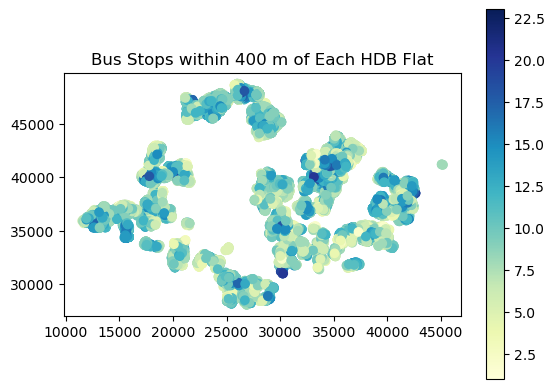

In [9]:
hdb.plot(column='bus_count_400m', cmap='YlGnBu', legend=True)
plt.title('Bus Stops within 400 m of Each HDB Flat')

In [10]:
# save results
hdb.to_parquet("processed_n/hdb_features.parquet")

<Axes: >

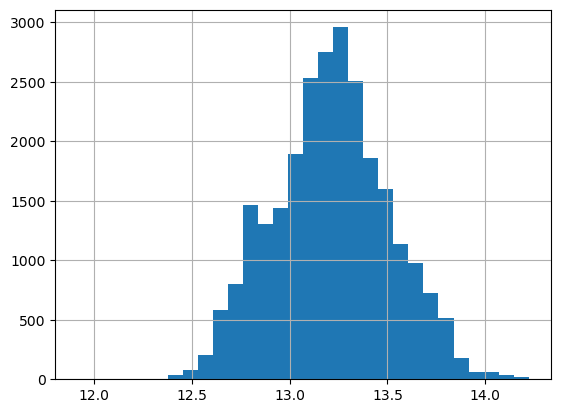

In [13]:
"""
Quick Exploratory Data Analysis
"""
# histogram
hdb['log_price'].hist(bins=30)


<Axes: >

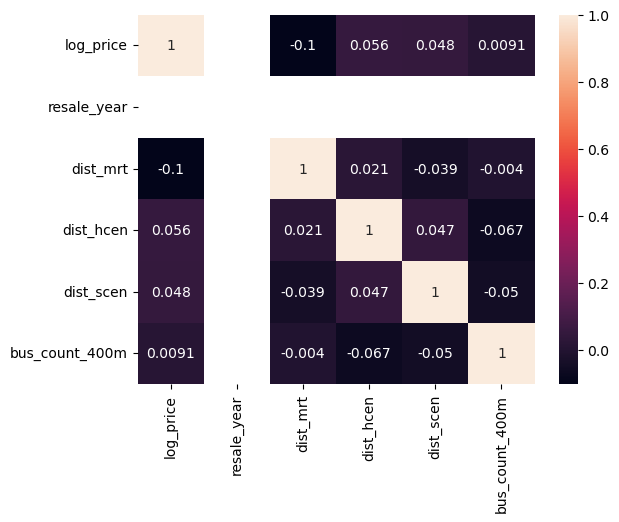

In [16]:
# Correlation check
import seaborn as sns, matplotlib.pyplot as plt

sns.heatmap(hdb[['log_price', 'resale_year', 'dist_mrt', 'dist_hcen', 'dist_scen', 'bus_count_400m']].corr(), annot=True)

In [18]:
!pip install contextily

   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/25.5 MB 5.9 MB/s eta 0:00:05
    --------------------------------------- 0.5/25.5 MB 6.4 MB/s eta 0:00:04
   - -------------------------------------- 1.1/25.5 MB 8.6 MB/s eta 0:00:03
   -- ------------------------------------- 1.5/25.5 MB 9.8 MB/s eta 0:00:03
   -- ------------------------------------- 1.5/25.5 MB 9.8 MB/s eta 0:00:03
   -- ------------------------------------- 1.7/25.5 MB 6.3 MB/s eta 0:00:04
   --- ------------------------------------ 2.2/25.5 MB 7.1 MB/s eta 0:00:04
   ---- ----------------------------------- 2.8/25.5 MB 7.8 MB/s eta 0:00:03
   ----- ---------------------------------- 3.5/25.5 MB 8.5 MB/s eta 0:00:03
   ------ --------------------------------- 4.1/25.5 MB 8.9 MB/s eta 0:00:03
   ------- -------------------------------- 4.7/25.5 MB 9.3 MB/s eta 0:00:03
   -------- ------------------------------- 5.3/25.5 MB 9.7 MB/s eta 0:00:03
   ---

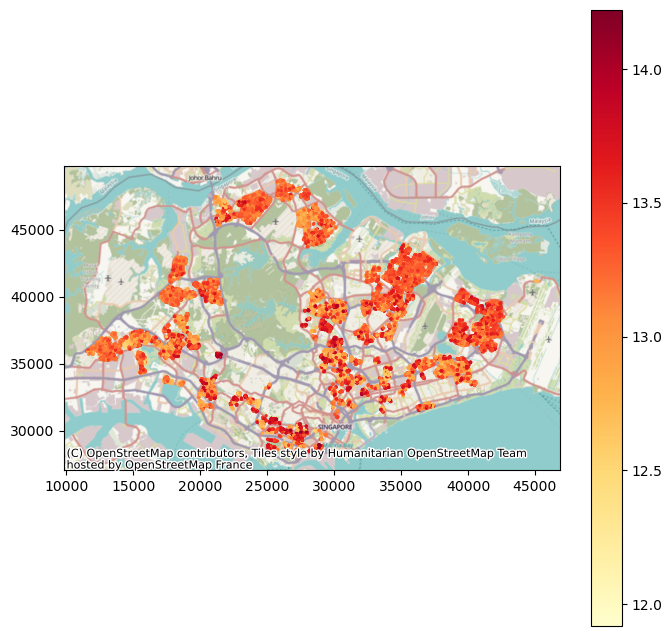

In [20]:
"""
KDE spatial hot spots
"""
import contextily as ctx

fig, ax = plt.subplots(figsize=(8,8))
hdb.plot(ax=ax, column='log_price', cmap='YlOrRd', markersize=2, legend=True)
ctx.add_basemap(ax, crs=hdb.crs.to_string())